##### Copyright 2021 The TensorFlow Authors.

In [1]:
#This code is inspired from: https://www.tensorflow.org/tutorials/audio/transfer_learning_audio
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/transfer_learning_audio"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/transfer_learning_audio.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/transfer_learning_audio.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/transfer_learning_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/yamnet/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

## Import TensorFlow and other libraries


Start by installing [TensorFlow I/O](https://www.tensorflow.org/io), which will make it easier for you to load audio files off disk.

In [1]:
!pip install tensorflow_io

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 22.5/22.5 MB 877.1 kB/s eta 0:00:00


In [4]:
#Importing required libraries
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

## About YAMNet

[YAMNet](https://github.com/tensorflow/models/tree/master/research/audioset/yamnet) is a pre-trained neural network that employs the [MobileNetV1](https://arxiv.org/abs/1704.04861) depthwise-separable convolution architecture. It can use an audio waveform as input and make independent predictions for each of the 521 audio events from the [AudioSet](http://g.co/audioset) corpus.

Internally, the model extracts "frames" from the audio signal and processes batches of these frames. This version of the model uses frames that are 0.96 second long and extracts one frame every 0.48 seconds .

The model accepts a 1-D float32 Tensor or NumPy array containing a waveform of arbitrary length, represented as single-channel (mono) 16 kHz samples in the range `[-1.0, +1.0]`. This tutorial contains code to help you convert WAV files into the supported format.

The model returns 3 outputs, including the class scores, embeddings (which you will use for transfer learning), and the log mel [spectrogram](https://www.tensorflow.org/tutorials/audio/simple_audio#spectrogram). You can find more details [here](https://tfhub.dev/google/yamnet/1).

One specific use of YAMNet is as a high-level feature extractor - the 1,024-dimensional embedding output. You will use the base (YAMNet) model's input features and feed them into your shallower model consisting of one hidden `tf.keras.layers.Dense` layer. Then, you will train the network on a small amount of data for audio classification _without_ requiring a lot of labeled data and training end-to-end. (This is similar to [transfer learning for image classification with TensorFlow Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) for more information.)

First, you will test the model and see the results of classifying audio. You will then construct the data pre-processing pipeline.

### Loading YAMNet from TensorFlow Hub

You are going to use a pre-trained YAMNet from [Tensorflow Hub](https://tfhub.dev/) to extract the embeddings from the sound files.

Loading a model from TensorFlow Hub is straightforward: choose the model, copy its URL, and use the `load` function.

Note: to read the documentation of the model, use the model URL in your browser.

In [6]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

With the model loaded, you can follow the [YAMNet basic usage tutorial](https://www.tensorflow.org/hub/tutorials/yamnet) and download a sample WAV file to run the inference.


In [61]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [192]:
meta_csv = 'C:/Users/sachinksingh/skipit/dataset/gtzan-sachin-meta.csv'
base_data_path = 'C:/Users/sachinksingh/skipit/dataset/audio/'

pd_data = pd.read_csv(meta_csv)
pd_data.head()

,filename,target,category,fold
0,bagpipe.wav,0,music,1
1,ballad.wav,0,music,1
2,bartok.wav,0,music,1
3,beat.wav,0,music,1
4,beatles.wav,0,music,1


### Data Selection

Now that the data is stored in the `DataFrame`, apply some transformations:

In [83]:
my_classes = ['music', 'speech']
map_class_to_id = {'music':0, 'speech':1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,target,category,fold
0,C:/Users/sachinksingh/skipit/dataset/audio/bag...,0,music,1
1,C:/Users/sachinksingh/skipit/dataset/audio/bal...,0,music,1
2,C:/Users/sachinksingh/skipit/dataset/audio/bar...,0,music,1
3,C:/Users/sachinksingh/skipit/dataset/audio/bea...,0,music,1
4,C:/Users/sachinksingh/skipit/dataset/audio/bea...,0,music,1
5,C:/Users/sachinksingh/skipit/dataset/audio/big...,0,music,1
6,C:/Users/sachinksingh/skipit/dataset/audio/bir...,0,music,1
7,C:/Users/sachinksingh/skipit/dataset/audio/blu...,0,music,1
8,C:/Users/sachinksingh/skipit/dataset/audio/bma...,0,music,1
9,C:/Users/sachinksingh/skipit/dataset/audio/bra...,0,music,1


### Load the audio files and retrieve embeddings

Here you'll apply the `load_wav_16k_mono` and prepare the WAV data for the model.

When extracting embeddings from the WAV data, you get an array of shape `(N, 1024)`  where `N` is the number of frames that YAMNet found (one for every 0.48 seconds of audio).

Your model will use each frame as one input. Therefore, you need to create a new column that has one frame per row. You also need to expand the labels and the `fold` column to proper reflect these new rows.

The expanded `fold` column keeps the original values. You cannot mix frames because, when performing the splits, you might end up having parts of the same audio on different splits, which would make your validation and test steps less effective.

In [84]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [85]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [86]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

### Split the data

You will use the `fold` column to split the dataset into train, validation and test sets.

I arranged dataset into five uniformly-sized cross-validation `fold`s, such that clips from the same original source are always in the same `fold` 

The last step is to remove the `fold` column from the dataset since you're not going to use it during training.


In [87]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

## Create your model

You did most of the work!
Next, define a very simple [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model with one hidden layer and two outputs to recognize cats and dogs from sounds.


In [88]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dense_6 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [89]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [90]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
146/146 [==============================] - 100s 606ms/step - loss: 0.1040 - accuracy: 0.9770 - val_loss: 0.0153 - val_accuracy: 0.9948
Epoch 2/20
146/146 [==============================] - 2s 11ms/step - loss: 0.0137 - accuracy: 0.9944 - val_loss: 0.0108 - val_accuracy: 0.9948
Epoch 3/20
146/146 [==============================] - 1s 10ms/step - loss: 0.0092 - accuracy: 0.9970 - val_loss: 0.0047 - val_accuracy: 0.9987
Epoch 4/20
146/146 [==============================] - 1s 10ms/step - loss: 0.0068 - accuracy: 0.9974 - val_loss: 0.0026 - val_accuracy: 0.9987
Epoch 5/20
146/146 [==============================] - 2s 10ms/step - loss: 0.0053 - accuracy: 0.9978 - val_loss: 0.0038 - val_accuracy: 0.9987
Epoch 6/20
146/146 [==============================] - 2s 10ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.0031 - val_accuracy: 0.9974
Epoch 7/20
146/146 [==============================] - 1s 10ms/step - loss: 0.0038 - accuracy: 0.9987 - val_loss: 0.0037 - val_accuracy: 0.9

Let's run the `evaluate` method on the test data just to be sure there's no overfitting.

In [91]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

55/55 [==============================] - 2s 5ms/step - loss: 0.1083 - accuracy: 0.9844
Loss:  0.10830574482679367
Accuracy:  0.9844470024108887


You did it!

## Test your model

Next, try your model on the embedding from the previous test using YAMNet only. Lets first create music and speech file from load_wav_16k_mono function. Then we will pass these files to see if our model is able to predict correctly or not.


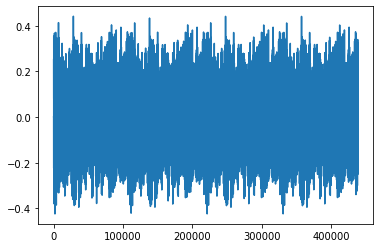

In [194]:


testing_wav_file_name_music=r'C:/Users/sachinksingh/skipit/dataset/test/ChillingMusic.wav'
testing_wav_data_music = load_wav_16k_mono(testing_wav_file_name_music)

_ = plt.plot(testing_wav_data_music)

# Play the audio file.
display.Audio(testing_wav_data_music,rate=16000)

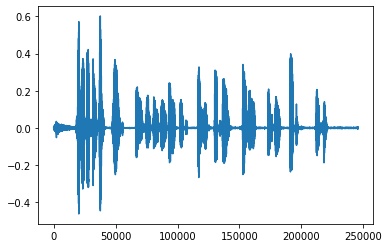

In [197]:
testing_wav_file_name_speech=r'C:/Users/sachinksingh/skipit/dataset/test/speech_sample.wav'
testing_wav_data_speech = load_wav_16k_mono(testing_wav_file_name_speech)

_ = plt.plot(testing_wav_data_speech)

# Play the audio file.
display.Audio(testing_wav_data_speech,rate=16000)

### Spot difference

We can clearly observe above, the difference between two spectrographs for music and speech respectevely.

In [161]:
#Starting test. 

scores, embeddings, spectrogram = yamnet_model(testing_wav_data_speech)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: speech


### Lets try to create a real time scenario

Cool as our model now able to classify the audio files correctly between speech and music, but thats not the actual motivation. We wanted to skip music whenever our video encounter it unlike single file classification. So lets try to create single audio file having music and speech both. I am trying to make things in very basic way from now onwards so that it will be really easy to understand concept. We can do these things in more efficient way but I believe simplicity is the best policy whenever we are starting a new thing.

In [110]:
from pydub import AudioSegment

sound1 = AudioSegment.from_wav(testing_wav_file_name_music)
sound2 = AudioSegment.from_wav(testing_wav_file_name_speech)

combined_sounds =  sound2+sound1
combined_sounds.export("C:/Users/sachinksingh/skipit/dataset/test/testing_wav_file_name_combo2.wav", format="wav")

testing_wav_file_name_combo = "C:/Users/sachinksingh/skipit/dataset/test/testing_wav_file_name_combo2.wav"



Now lets try to create chunks from the combo file. We will run our model on these chunks to predict music/speech. This will mimic the real time scenario where audio is continuously getting sampled.

In [168]:
from pydub import AudioSegment
from pydub.utils import make_chunks


audio = AudioSegment.from_wav(testing_wav_file_name_combo)
audio_duration=audio.duration_seconds
audio = AudioSegment.from_file(testing_wav_file_name_combo , "wav") 
chunk_length_ms = 10000 # pydub calculates in millisec
chunks = make_chunks(audio, chunk_length_ms) #Make chunks of one sec


Lets run our model for each chunk:

In [191]:
for i, chunk in enumerate(chunks):
    chunk_name = "C:/Users/sachinksingh/skipit/dataset/chunks/chunk{0}.wav".format(i)
# Uncomment below line in case you want to export chunks.
#     chunk.export(chunk_name, format="wav")
    testing_chunk = load_wav_16k_mono(chunk_name)
    
    x,embeddings,y = yamnet_model(testing_chunk)
    result = my_model(embeddings).numpy()

    inferred_class = my_classes[result.mean(axis=0).argmax()]
    print(f'The main sound is: {inferred_class}')

The main sound is: speech
The main sound is: speech
The main sound is: music
The main sound is: music
The main sound is: music
